## makenpy

np.arange(0,np.pi,np.pi / 4) [0.         0.78539816 1.57079633 2.35619449]
np.pi 3.141592653589793
len 4
len(filters) 4
[[0.         0.         0.         ... 0.00784314 0.21568627 0.        ]]
第1次
len(filters) 4
[[0.         0.         0.         ... 0.05490196 0.05098039 0.        ]]
第2次
len(filters) 4
[[0.         0.         0.         ... 0.21176471 0.04705882 0.        ]]
第3次
len(filters) 4
[[0. 0. 0. ... 0. 0. 0.]]
第4次
len(filters) 4
[[0. 0. 0. ... 0. 0. 0.]]
第5次
len(filters) 4
[[0.01176471 0.         0.01176471 ... 0.         0.         0.        ]]
第6次
len(filters) 4
[[0.         0.         0.         ... 0.57254902 0.6        1.        ]]
第7次
len(filters) 4
[[0.01176471 0.49411765 0.24313725 ... 0.31372549 0.18039216 1.        ]]
第8次
len(filters) 4
[[0.         0.50196078 0.24313725 ... 0.31372549 0.31372549 1.        ]]
第9次
len(filters) 4
[[0.         0.50196078 0.49411765 ... 0.31372549 0.31372549 1.        ]]
第10次
len(filters) 4
[[0.         0.         0.         ... 0.3137

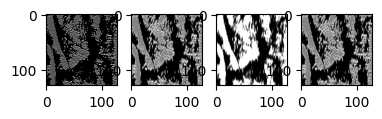

In [23]:
from tarfile import BLOCKSIZE
import cv2
import numpy as np
import pylab as pl
import os

#制作滤波器build_filters
def build_filters():
    filters = []
    # ksize = [7,9,11,13,15,17] #gaboreize，6个
    ksize = [11] #gaborsize，1个
    lamda = np.pi/1.0 #波长
    for theta in np.arange(0,np.pi,np.pi / 4): #gabor angle，0 45,90,135
        for K in range(len(ksize)):
            kern = cv2.getGaborKernel((ksize[K],ksize[K]),1.0,theta,lamda,0.5,0,ktype=cv2.CV_32F)
            kern /= 1.2*kern.sum()
            filters.append(kern)
    print("np.arange(0,np.pi,np.pi / 4)",np.arange(0,np.pi,np.pi / 4))
    print("np.pi",np.pi)
    print("len",len(filters))
    return filters

def process(img,filters):
    accum = np.zeros_like(img)
    for kern in filters:
        fimg = cv2.filter2D(img,cv2.CV_8UC3,kern)
        np.maximum(accum,fimg,accum)
    return accum

#Gabor
def getGabor(img,filters):
    print('len(filters)',len(filters))
    res = [] #result of filting
    for i in range(len(filters)):
        res1 = process(img,filters[i])
        res.append(np.asarray(res1))
    pl.figure(2)
    for temp in range(len(res)):
        pl.subplot(4,6,temp+1)
        pl.imshow(res[temp],cmap='gray')
    #pl.show()
    return res

#normalization
def normalization(data):
    return data / np.max(abs(data))
#feature and save
def make_feature(filters):
    #Used to hold the current category label (represented by the value of the outer loop i)
    #The list of y-compression tags is added to the last dimension of the feature matrix of each image, i.e., flattened.
    class_list = []
    #Stack the feature vectors of all the images and get a feature matrix of size (500,16384).
    #Initialized to [[0]]
    stack_metrix = np.array([[0]])
    count=0
    for i in range(0, 102):
        class_list.append(i)
        class_matrix = np.array(class_list, ndmin=2)
        for j in range(1, 7):
            path = '/content/drive/MyDrive/plam/ROI/P_{}_{}.bmp'.format(i, j)
            x = cv2.imread(path)
            x = cv2.cvtColor(x,cv2.COLOR_BGR2GRAY)
            x = cv2.adaptiveThreshold(x, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, blocksize, C)
            # cv2.imshow("x",x)
            cv2.waitKey(0)
            data=getGabor(x,filters)
            data = np.asarray(data)
            data=normalization(data)
            data = np.reshape(data, (1, -1))
            one_data = np.column_stack((data, class_matrix))
            print(one_data)
            count=count+1
            print('第{}次'.format(count))
            # 第一次不堆叠
            np.save('/content/drive/MyDrive/plam/ROI/P_{}_{}.npy'.format(i, j),one_data)
            if j<7:
            # Not letting the sixth image into (new3)feature.npy (the sixth image as a final test)
                if i == 0 and j == 1:
                    stack_metrix = one_data
                    continue
                stack_metrix = np.row_stack((stack_metrix, one_data))
        class_list.pop()
    np.save('(new3)feature.npy', stack_metrix)

if __name__ == '__main__':
        blocksize=25
        C=-2
        path = "/content/drive/MyDrive/plam/ROI"
        path_list = os.listdir(path)
        path_list.sort()
        filters = build_filters()
        make_feature(filters)




In [25]:
cp "(new3)feature.npy" /content/drive/MyDrive/plam/

In [6]:
pip install pyecharts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.7/147.7 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 13.4 MB/s eta 0:00:00


In [24]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from pyecharts import options as opts
from pyecharts.charts import Bar
import joblib
import matplotlib.pyplot as plt
import cv2 as cv

## makemodel

In [26]:
N = int(65537)

def load_data():
    """
    Get the features of the sample as well as the category labels
    """
    # path = '(new)feature.txt'
    # train_data = np.loadtxt(path)
    path = '/content/drive/MyDrive/plam/(new3)feature.npy'
    train_data = np.load(path)
    data = train_data[:, :N]
    target = train_data[:, -1:]
    # print(train_data)
    print(train_data.shape)
    return data, target

def load_test(i,j):
    """
    Get the features of the test image as well as the category tags
    """
    path = '/content/drive/MyDrive/plam/ROI/P_{}_{}.npy'.format(i, j)
    test_data = np.load(path)
    data = test_data[:, :N]
    target = test_data[:, -1:]
    return data, target
# def test(i):


def train(i):
    # """
    # 1.PCA+SVM for classification or PCA+KNN
    # 2.PCA downscaling to i-dimension
    # :return:
    # """
    data, target = load_data()
    x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.1666666666666666666666666667, random_state=10)
    # Randomly divide the dataset


    # pca_train.append("pca降至{:.0f}维".format(i))
    # pca = PCA(n_components=i)#Import PCA and automate the model by changing the number of dimensionality reductions in PCA
    # x_train = pca.fit_transform(x_train)
    svm_clf = SVC(C=100)#Setting the penalty parameter C of SVM to 100, supervised learning makes its classification more accurate
    svm_clf.fit(x_train, y_train.ravel())
    my_model = KNeighborsClassifier(algorithm='kd_tree', p=5, n_neighbors=1)
    my_model.fit(x_train, y_train.ravel())

    joblib.dump(my_model, 'pca_num={}_train_model.m'.format(i))
    my_model = joblib.load('pca_num={}_train_model.m'.format(i))
    joblib.dump(svm_clf, 'pca_num={}_train_svm_clf.m'.format(i))
    svm_clf = joblib.load('pca_num={}_train_svm_clf.m'.format(i))

    x_test_process = (x_test)
    svm_score = svm_clf.score(x_test_process, y_test)
    knn_score = my_model.score(x_test_process,y_test)
    print("pca_num={}".format(i))
    print('svm测试集上的预测精度为:{}'.format(svm_score))
    print('knn测试集上的预测精度为:{}'.format(knn_score))

if __name__ == '__main__':
    # pca_num=[10,20,30,40,48,50,51,52,55,60,65]
    pca_num = [44]
    accuracy_svm = []
    accuracy_knn = []
    pca_train=[]
    for i in pca_num:
        train(i)

(612, 65537)
pca_num=44
svm测试集上的预测精度为:1.0
knn测试集上的预测精度为:1.0


In [27]:
cp  "/content/pca_num=44_train_model.m" /content/drive/MyDrive/plam

In [28]:
cp  "/content/pca_num=44_train_svm_clf.m" /content/drive/MyDrive/plam

## test

In [29]:
N = int(65537)
import time
def load_test(i,j):
    """
    Get the features of the test image as well as the category tags
    """
    path = '/content/drive/MyDrive/plam/ROI/P_{}_{}.npy'.format(i, j)
    test_data = np.load(path)
    data = test_data[:, :N]
    target = test_data[:, -1:]
    return data, target
# def test(i):


def test(j):
    my_model = joblib.load('/content/drive/MyDrive/plam/pca_num=44_train_model.m'.format(j))
    svm_clf = joblib.load('/content/drive/MyDrive/plam/pca_num=44_train_svm_clf.m'.format(j))
    data2,target2 = load_test(j,6)
    print("svm = predict =",svm_clf.predict(data2))
    print("knn = predict =",my_model.predict(data2))
if __name__ == '__main__':
    j = input("label = ")
    t1 = time.time()
    test(j)
    print(time.time()-t1)


label = 101
svm = predict = [101.]
knn = predict = [101.]
2.877523899078369


In [30]:
N = int(65537)
import time
def load_test(i,j):
    """
    Get the features of the test image as well as the category tags
    """
    path = '/content/drive/MyDrive/plam/ROI/P_{}_{}.npy'.format(i, j)
    test_data = np.load(path)
    data = test_data[:, :N]
    target = test_data[:, -1:]
    return data, target

def test(j):
    my_model = joblib.load('/content/drive/MyDrive/plam/pca_num=44_train_model.m'.format(j))
    svm_clf = joblib.load('/content/drive/MyDrive/plam/pca_num=44_train_svm_clf.m'.format(j))
    data2,target2 = load_test(j,6)
    return [svm_clf.predict(data2)[0],my_model.predict(data2)[0]]

if __name__ == '__main__':
    sucess = 0
    for j in range(1,102):
        temp = test(j)
        if j == temp[1] and j == temp[0]:
            sucess += 1
        else:
            print(j)
    print(sucess/101)


1.0
